# Bank Customer Churn Prediction

## 1) Import Necessaries

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
import joblib

## 2) EDA

In [220]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [221]:
df.shape

(10000, 14)

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 3) Data Cleaning

In [223]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [224]:
new_df = df.drop(columns = ["Surname", "CustomerId", "RowNumber"])

In [225]:
new_df.shape

(10000, 11)

In [226]:
print(f"The number of unique values in each column in Bank Customer Churn dataset:\n")
new_df.nunique()

The number of unique values in each column in Bank Customer Churn dataset:



CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

## 4) Correlation Analysis

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7620\3572352391.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(new_df.corr(), xticklabels=df.corr().columns, yticklabels=new_df.corr().columns, cmap='RdYlGn', center=0, annot=True)


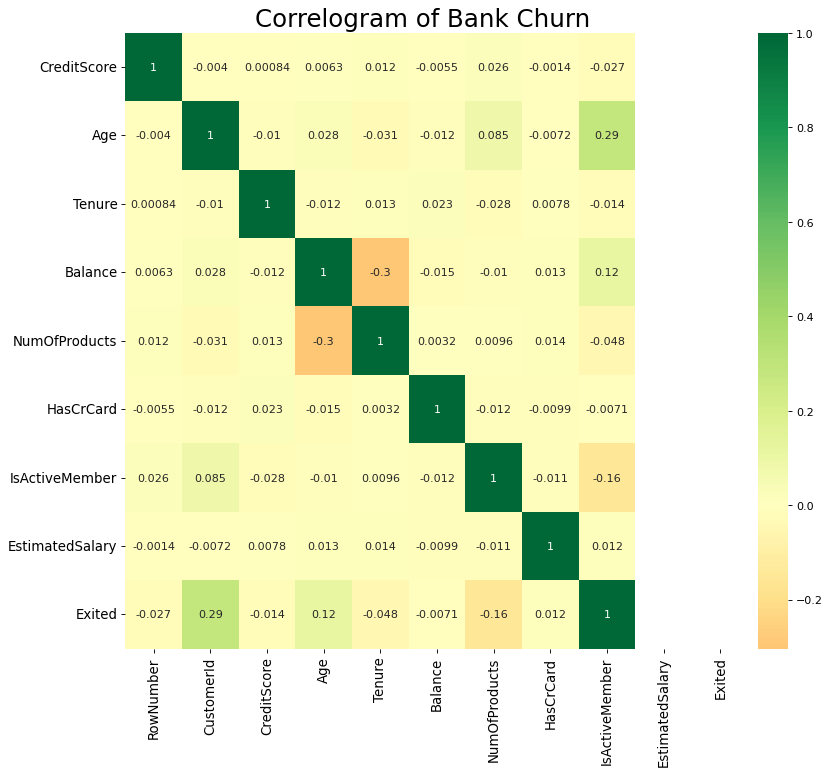

In [227]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(new_df.corr(), xticklabels=df.corr().columns, yticklabels=new_df.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram of Bank Churn', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [228]:
for col in new_df.columns:
    if (new_df[col].dtype == "object") | (new_df[col].nunique()<5):
        contingency_table = pd.crosstab(new_df[col], new_df["Exited"])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"{col} Chi-square statistic: {chi2}, P-value: {'{:.4f}'.format(p)}")

Geography Chi-square statistic: 301.25533682434536, P-value: 0.0000
Gender Chi-square statistic: 112.91857062096116, P-value: 0.0000
NumOfProducts Chi-square statistic: 1503.6293615070408, P-value: 0.0000
HasCrCard Chi-square statistic: 0.47133779904440803, P-value: 0.4924
IsActiveMember Chi-square statistic: 242.98534164287963, P-value: 0.0000
Exited Chi-square statistic: 9993.835961897581, P-value: 0.0000


In [229]:
for col in new_df.columns:
    if  (new_df[col].nunique()>10):
        correlation, p_value = pointbiserialr(df['Exited'], df[col])
        print(f"{col}:: Point-Biserial Correlation: {correlation}, P-value: {'{:.4f}'.format(p_value)}")


CreditScore:: Point-Biserial Correlation: -0.027093539754656896, P-value: 0.0067
Age:: Point-Biserial Correlation: 0.28532303783505886, P-value: 0.0000
Tenure:: Point-Biserial Correlation: -0.014000612253444372, P-value: 0.1615
Balance:: Point-Biserial Correlation: 0.1185327687716301, P-value: 0.0000
EstimatedSalary:: Point-Biserial Correlation: 0.012096861026844317, P-value: 0.2264


In [230]:
dropColumns = ["HasCrCard", "Tenure"]
new_df.drop(columns = dropColumns, inplace = True)

In [231]:
new_df = pd.get_dummies(new_df, columns=['Geography', 'Gender'])

## 5) Split the data into train and test datasets

In [232]:
x = new_df.drop(columns = "Exited")
y = new_df["Exited"]
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y,   
                                                    test_size=0.3, 
                                                    random_state= 123)
                                                   

## 6) Feature Scaling

In [233]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 7) Data Modeling and Evaluation

In [234]:
lr = LogisticRegression(max_iter = 1000)
poly = PolynomialFeatures(degree = 3)
X_train_p = poly.fit_transform(X_train)
X_test_p = poly.transform(X_test)
lr.fit(X_train_p, y_train)
y_perd = lr.predict(X_test_p)
accuracy = accuracy_score(y_test, y_perd)
print(f"The Accuarcy of Logistic Regression on the testing data: {accuracy*100:.2f}%")

The Accuarcy of Logistic Regression on the testing data: 87.47%


In [235]:
y_ = lr.predict(X_train_p)
accuracy = accuracy_score(y_train, y_)
print(f"The Accuarcy of Logistic Regression on the training data: {accuracy*100:.2f}%")

The Accuarcy of Logistic Regression on the training data: 86.84%


In [236]:
scaler = StandardScaler()
X = scaler.fit_transform(x)
lr_model = LogisticRegression(max_iter = 1000)
poly = PolynomialFeatures(degree = 3)
X_p = poly.fit_transform(X)
lr_model.fit(X_p, y)
# Save the model to a file
joblib.dump((scaler, poly, lr_model), 'trained_model.pkl')

['trained_model.pkl']

In [237]:
sampled_data = df.sample(n=10)
new_df = sampled_data.drop(columns = ["Surname", "CustomerId", "RowNumber","HasCrCard", "Tenure"])
X_new = new_df.drop(columns = "Exited")
y = new_df["Exited"]
X_new = pd.get_dummies(X_new, columns=['Geography', 'Gender'])
# Load the saved model
scaler, poly, lr_model = joblib.load('trained_model.pkl')
X_new_scal = scaler.transform(X_new)
X_new_p = poly.transform(X_new_scal)
predictions = lr_model.predict(X_new_p)
accuracy = accuracy_score(y, predictions)
# Create a DataFrame with CustomerId and predicted Exited values
result_df = pd.DataFrame({'CustomerId': sampled_data['CustomerId'], 'Exited_Prediction': predictions})
print(result_df)

      CustomerId  Exited_Prediction
6474    15626143                  0
816     15734565                  0
150     15650237                  0
2464    15725818                  0
928     15677135                  0
5403    15733169                  0
7738    15768746                  0
7989    15605827                  0
6798    15799925                  0
9236    15635388                  1
